In [1]:
import cv2
import math
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from keras.preprocessing import image
import numpy as np
from keras.utils import np_utils
from skimage.transform import resize
from PIL import Image
import re
import os
import random
import shutil
import keras
from keras.models import load_model

In [2]:
import os
import urllib.request
url = "https://onedrive.live.com/download?cid=6906019B94799E0F&resid=6906019B94799E0F%211317&authkey=AAZ6VGVqYiX7WGE"
filename = 'dataset6.zip'
urllib.request.urlretrieve(url, filename)

('dataset6.zip', <http.client.HTTPMessage at 0x7f107525dc90>)

In [3]:
import zipfile
with zipfile.ZipFile("dataset6.zip", 'r') as zip_ref:
    zip_ref.extractall("files")

In [4]:
os.chdir("./files")

In [5]:
# Loading video names in a column and labels:
os.getcwd()
path=''
video_directory=os.path.join(path,"videos")
videos=os.listdir(video_directory)

label=[]
for i in videos:
    if "no_eat_" in i:
        label.append(0)
    elif "eat_" in i:
        label.append(1)
    else:
        label.append("file_name_incorrect")
        
videos=pd.DataFrame(videos,label).reset_index()
videos.columns=["labels","video_name"]

videos.groupby('labels').count()

,video_name
labels,
0,800
1,705


In [6]:
train_set = pd.DataFrame()
test_set = pd.DataFrame()
train_video = []
test_video = []
train_label = []
test_label = []
for i in range(len(videos)):
  if "train" in videos['video_name'][i]:
    train_video.append(videos['video_name'][i])
    train_label.append(videos['labels'][i])
  elif "test" in videos['video_name'][i]:
    test_video.append(videos['video_name'][i])
    test_label.append(videos['labels'][i])

train_set['labels'] = train_label
train_set['video_name'] = train_video

test_set['labels'] = test_label
test_set['video_name'] = test_video



In [7]:
print(train_set.groupby('labels').count())
print(test_set.groupby('labels').count())

        video_name
labels            
0              560
1              465
        video_name
labels            
0              240
1              240


In [8]:
path = ""
hair_dir_path=os.path.join(path,'train_test')
train_videos_dir=os.path.join(hair_dir_path,"Train_Videos")
test_videos_dir=os.path.join(hair_dir_path,"Test_Videos")
try:
    os.mkdir(hair_dir_path)
except FileExistsError as ae:
    print("Folder Already Created")

try:
    os.mkdir(train_videos_dir)
except FileExistsError as ae:
    print("Folder Already Created")
    
try:
    os.mkdir(test_videos_dir)
except FileExistsError as ae:
    print("Folder Already Created")

In [9]:
#Reading the video files, extracting frames from each corresponding video and putting them in the respective train/test folder:
hair_path=os.path.join(path,"train_test")

def video_capturing_function(dataset,folder_name):
    for i in np.arange(len(dataset)):
        video_name=dataset.video_name[i]
        video_read_path=os.path.join(video_directory,video_name)
        cap=cv2.VideoCapture(video_read_path)
        try:
            os.mkdir(os.path.join(os.path.join(hair_path,folder_name),
                                  video_name.split(".")[0]))
        except:
            print("File Already Created")
        
        train_write_file=os.path.join(os.path.join(hair_path,folder_name),
                                  video_name.split(".")[0])
        cap.set(cv2.CAP_PROP_FPS, 20)
        frameRate=cap.get(5)
        x=1
        count=0
        while(cap.isOpened()):
            frameId = cap.get(1) #current frame number
            ret, frame = cap.read()
            if (ret != True):
                break
            if (frameId % math.floor(frameRate) == 0):
                filename ="frame%d.jpg" % count;count+=1
                frame_grey=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                cv2.imwrite(os.path.join(train_write_file,filename), frame_grey)
        cap.release()
    return print("All frames written in the: "+folder_name+" Folder")
    
video_capturing_function(train_set,"Train_Videos")
video_capturing_function(test_set,"Test_Videos")

All frames written in the: Train_Videos Folder
All frames written in the: Test_Videos Folder


In [10]:
# Code to see how many frames are captured for each video:
train_dir_path='train_test/Train_Videos'
test_dir_path='train_test/Test_Videos'

vid_file_name=train_set.video_name[0].split('.')[0]

train_frames=[]
for i in np.arange(len(train_set.video_name)):
    vid_file_name=train_set.video_name[i].split('.')[0]
    train_frames.append(len(os.listdir(os.path.join(train_dir_path,vid_file_name))))

test_frames=[]
for i in np.arange(len(test_set.video_name)):
    vid_file_name=test_set.video_name[i].split('.')[0]
    test_frames.append(len(os.listdir(os.path.join(test_dir_path,vid_file_name))))

In [11]:
def frame_generating_function(dataset,dir_path):
    for i in np.arange(len(dataset.video_name)):
        vid_namu=dataset.video_name[i]
        vid_path=os.path.join(dir_path,vid_namu.split(".")[0])
        len_frame=len(os.listdir(vid_path))
        j=10-len(os.listdir(vid_path))
        if j>0:
            list_frames=os.listdir(vid_path)
            c=0
            for k in np.arange(j):
                list_frames=os.listdir(vid_path)
                frame=os.path.join(vid_path,list_frames[c])
                countu=k+len_frame
                new_frame="frame%d.jpg" % countu
                shutil.copy2(frame,os.path.join(vid_path,new_frame))
                c+=1
        else:
            pass
    return print("Frame Generation Done!")
    
frame_generating_function(train_set,train_dir_path)
frame_generating_function(test_set,test_dir_path)

Frame Generation Done!
Frame Generation Done!


In [12]:
# Train and Validation Splitting:
label_1_dat=train_set.loc[train_set["labels"]==1,]
label_0_dat=train_set.loc[train_set["labels"]==0,]

train_len_label1=math.floor(len(label_1_dat)*0.80)
train_len_label0=math.floor(len(label_0_dat)*0.80)

train_dat_label1=label_1_dat.iloc[:train_len_label1,]
train_dat_label0=label_0_dat.iloc[:train_len_label0,]

validation_dat_label1=label_1_dat.iloc[train_len_label1:,]
validation_dat_label0=label_0_dat.iloc[train_len_label0:,]

train_vid_dat=train_dat_label1.append(train_dat_label0,ignore_index=True)
validation_vid_dat=validation_dat_label1.append(validation_dat_label0,ignore_index=True)

In [13]:
# Data load function for 10 frames:

def data_load_function_10frames(dataset,directory):
    frames=[]
    for i in np.arange(len(dataset)):
        vid_name=dataset.video_name[i].split(".")[0]
        vid_dir_path=os.path.join(directory,vid_name)
        frames_to_select=[]
        for l in np.arange(0,10):
            frames_to_select.append('frame%d.jpg' % l)
        vid_data=[]
        for frame in frames_to_select:
            image=Image.open(os.path.join(vid_dir_path,frame))
            image=image.resize((250, 250), Image.ANTIALIAS) 
            datu=np.asarray(image)
            normu_dat=datu/255
            vid_data.append(normu_dat)
        vid_data=np.array(vid_data)
        frames.append(vid_data)
    return np.array(frames)

In [14]:
# 10 frames train,validation and test data:

test_dataset_new=data_load_function_10frames(test_set,test_dir_path)
train_dataset_new=data_load_function_10frames(train_vid_dat,train_dir_path)
validation_dataset_new=data_load_function_10frames(validation_vid_dat,train_dir_path)

test_labels=np.array(test_set.labels)
train_labels=np.array(train_vid_dat.labels)
validation_labels=np.array(validation_vid_dat.labels)

In [15]:
# Reshaping tensors to confirm with the model we are going to train:
test_dataset_new=test_dataset_new.reshape((test_dataset_new.shape[0],10,250,250,1))
train_dataset_new=train_dataset_new.reshape((train_dataset_new.shape[0],10,250,250,1))
validation_dataset_new=validation_dataset_new.reshape((validation_dataset_new.shape[0],10,250,250,1))

In [16]:
baseline_predictions=np.ones(len(test_labels))
test_accuracy_naive=np.where(baseline_predictions==test_labels)[0].shape[0]/len(test_labels)
test_accuracy_naive

0.5

In [17]:
from keras.layers import Conv3D, MaxPooling3D, BatchNormalization, Dropout, Dense, Flatten, concatenate
from keras.models import Model
from keras import Input
# 3D Convolutional Model:
input_model=Input(shape=(10,250,250,1))
layer=Conv3D(32,(3,3,3),strides=(1,1,1),activation='relu')(input_model)
layer=MaxPooling3D((2,2,2))(layer)
layer=Conv3D(64,(3,3,3),strides=(1,1,1),activation='relu')(layer)
layer=MaxPooling3D((2,2,2))(layer)
layer=BatchNormalization()(layer)
layer=Flatten()(layer)
layer=Dense(128,activation='relu')(layer)
layer=Dropout(0.1)(layer)
layer=Dense(64,activation='relu')(layer)
layer=Dense(32,activation='relu')(layer)
layer_output=Dense(1,activation='sigmoid')(layer)

model_3dConv=Model(input_model,layer_output)

model_3dConv.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 250, 250, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 8, 248, 248, 32)   896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 4, 124, 124, 32)   0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 2, 122, 122, 64)   55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 1, 61, 61, 64)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 61, 61, 64)     256       
_________________________________________________________________
flatten (Flatten)            (None, 238144)            0     

In [18]:
# Conv3d model training:
from keras import optimizers
optimizer_new=optimizers.RMSprop(lr=0.1)
optimizer_adagrad=keras.optimizers.Adagrad(lr=0.01)
callbacks_list_conv_3d=[keras.callbacks.EarlyStopping(
monitor='acc',patience=6),
               keras.callbacks.ModelCheckpoint(
               filepath='eat_model_conv_3d.h5',
               monitor='val_loss',
               save_best_only=True),
                        keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 2)
               ]
model_3dConv.compile(optimizer=optimizer_adagrad,loss='binary_crossentropy',metrics=['acc'])
conv_3d_model_history=model_3dConv.fit(train_dataset_new,train_labels,batch_size=10,epochs=15,
               validation_data=(validation_dataset_new,validation_labels),
               callbacks=callbacks_list_conv_3d)

Epoch 1/15
82/82 [==============================] - 26s 125ms/step - loss: 0.8595 - acc: 0.6844 - val_loss: 0.6426 - val_acc: 0.7415
Epoch 2/15
82/82 [==============================] - 10s 118ms/step - loss: 0.4568 - acc: 0.8145 - val_loss: 0.6308 - val_acc: 0.8341
Epoch 3/15
82/82 [==============================] - 10s 118ms/step - loss: 0.3427 - acc: 0.8636 - val_loss: 0.5266 - val_acc: 0.8488
Epoch 4/15
82/82 [==============================] - 10s 118ms/step - loss: 0.2760 - acc: 0.8927 - val_loss: 0.4713 - val_acc: 0.8390
Epoch 5/15
82/82 [==============================] - 10s 118ms/step - loss: 0.1524 - acc: 0.9387 - val_loss: 0.4568 - val_acc: 0.8341
Epoch 6/15
82/82 [==============================] - 10s 118ms/step - loss: 0.1192 - acc: 0.9526 - val_loss: 0.4506 - val_acc: 0.8244
Epoch 7/15
82/82 [==============================] - 10s 118ms/step - loss: 0.0833 - acc: 0.9764 - val_loss: 0.5394 - val_acc: 0.8000
Epoch 8/15
82/82 [==============================] - 10s 118ms/step - 

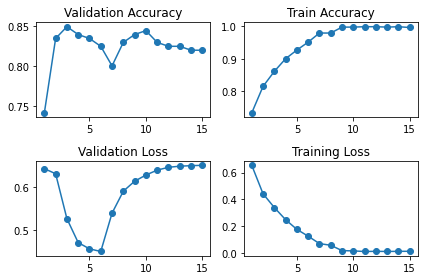

In [19]:
acc=conv_3d_model_history.history["acc"]
val_acc=conv_3d_model_history.history["val_acc"]
loss=conv_3d_model_history.history["loss"]
val_loss=conv_3d_model_history.history["val_loss"]


epochs=np.arange(1,16)

plt.figure()
plt.subplot(2,2,1)
plt.plot(epochs,val_acc,'-o')
plt.title('Validation Accuracy')

plt.subplot(2,2,2)
plt.plot(epochs,acc,'-o')
plt.title('Train Accuracy')

plt.subplot(2,2,3)
plt.plot(epochs,val_loss,'-o')
plt.title('Validation Loss')

plt.subplot(2,2,4)
plt.plot(epochs,loss,'-o')
plt.title('Training Loss')


plt.tight_layout()

In [20]:
model=load_model('eat_model_conv_3d.h5')

model.evaluate(test_dataset_new,test_labels)

15/15 [==============================] - 2s 134ms/step - loss: 0.4160 - acc: 0.8271


[0.41599634289741516, 0.8270833492279053]